### Training a Custom Deep Learning Model © Oxcitas Ltd.

---

## Imports and Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import json
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Add the parent directory of `src` to the Python path
sys.path.append(os.path.abspath('../'))

In [4]:
# Custom imports (placeholders for demonstration)
import src.constants as C
from src.data import Dataset
from src.models import Custom3DCNN, SFCN, resnet18
from src.utils import AWDLoss, KLDivLoss, augment, scheduler, discretize_ages, save_subject_ids, load_scan

## Configuration
Setting up constants and a small demonstration configuration.

In [5]:
# Constants for demonstration
CSIZE = 128  # Reduced size for faster processing
BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 0.001
BINS = 10
USE_SOFT_LABELS = False

In [6]:
# Load training configuration
config_path = Path('../configs/training_config.json').expanduser().resolve()
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

In [7]:
# Extract configuration parameters
PROJECT_NAME = config['project_name']
OUTPUT_DIRECTORY = Path(config['output_directory']).expanduser().resolve()
USE_SOFT_LABELS = config['use_soft_labels']
print(PROJECT_NAME) 
print(OUTPUT_DIRECTORY) 
print(USE_SOFT_LABELS)

deepMRI@demo
/Users/gathanasiou/oxcitas/UKB-gen-clocks/DL-apporach/configs/dataset_configs
False


---

## Back up functions

In [8]:
def prepare_data(dataset):
    """
    Prepare the dataset by appending file extensions to scan IDs.
    """
    dataset.scanIDs = [scan + '.mgz' for scan in dataset.scanIDs]
    return dataset

In [9]:
def create_data_batches(X_train, y_train, X_test, y_test, batch_size, soft_labels=False):
    """
    Create TensorFlow data batches for training and testing.
    """
    if soft_labels:
        train_labels = np.array([item for item in y_train])
        test_labels = np.array([item for item in y_test])
    else:
        train_labels = np.array(y_train)
        test_labels = np.array(y_test)

    train_scans = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
    test_scans = tf.data.Dataset.from_tensor_slices((X_test, test_labels))

    train_scans = train_scans.map(load_scan, num_parallel_calls=tf.data.AUTOTUNE).cache()
    test_scans = test_scans.map(load_scan, num_parallel_calls=tf.data.AUTOTUNE)
    
    BUFFER_SIZE = 500
    train_batches = (
        train_scans
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .filter(lambda x, y: tf.shape(x)[0] > 1)  # Filter out small batches
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    test_batches = test_scans.batch(batch_size).filter(lambda x, y: tf.shape(x)[0] > 1)  # Filter out small batches

    return train_batches, test_batches

In [10]:
def compile_model_real_labels(model, learning_rate):
    """
    Compile the model for real labels with the custom AWD loss function and Adam optimizer.
    """
    awdLoss = AWDLoss(num_bins=C.BINS, initial_alpha=C.ALPHA, initial_beta=C.BETA)
    
    def awd_loss(y_true, y_pred):
        return awdLoss(y_true, y_pred)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=awd_loss,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

---

## Data Preparation
Loading real data based on the provided configuration.

In [11]:
# Load dataset configuration
DATASET_CONFIG_PATH = OUTPUT_DIRECTORY / ('dataset_config_soft.json' if USE_SOFT_LABELS else 'dataset_config_real.json')
data = Dataset.from_file(DATASET_CONFIG_PATH)
data = prepare_data(data)

10
Target path:  ../configs/targets/real_targets.json


In [13]:
# Prepare train-test splits
for fold_num, (X_train, X_test, y_train, y_test) in enumerate(data.train_test_subjID_iterator(), 1):
    print(f"Training fold {fold_num}...")
    print(f"Number of cases in X_train: {len(X_train)}")
    print(f"Number of cases in X_test: {len(X_test)}")

    train_batches, test_batches = create_data_batches(X_train, y_train, X_test, y_test, BATCH_SIZE, soft_labels=USE_SOFT_LABELS)
    break  # Only load the first fold for this demonstration

Total subjects: 9
Training subjects: 6, Test subjects: 3
Train Scans: 7, Train Labels: 7
Test Scans: 3, Test Labels: 3
Formatted Train Labels Shape: (7,), Test Labels Shape: (3,)
Training fold 1...
Number of cases in X_train: 7
Number of cases in X_test: 3


---

## Training the Model
Training the model on a small dataset for a few epochs.

In [14]:
for fold_num, (X_train, X_test, y_train, y_test) in enumerate(data.train_test_subjID_iterator(), 1):
    print(f"Training fold {fold_num}...")
    print(f"Number of cases in X_train: {len(X_train)}")
    print(f"Number of cases in X_test: {len(X_test)}")

    # y_train_bins, train_bins = discretize_ages(y_train)
    # y_test_bins, test_bins = discretize_ages(y_test)

    model_pick = C.RESNET
    if USE_SOFT_LABELS:
        print("Soft labeling case initialized...")
        if model_pick:
            print("Using ResNet model...")
            model = resnet18(input_shape=(C.CSIZE, C.CSIZE, C.CSIZE, 1),
                     num_classes=int((C.HGH_BIN - C.LOW_BIN) / C.STEP_BIN), 
                     channel_size=[64, 64, 128, 256, 512], 
                     dropout=True)
        else:
            print("Using SFCN model...")
            model = SFCN(input_shape=(C.CSIZE, C.CSIZE, C.CSIZE, 1), 
                        channels=[32, 64, 128, 256, 256, 64], 
                        output_dim=int((C.HGH_BIN - C.LOW_BIN) / C.STEP_BIN), 
                        use_dropout=True, 
                        csize=C.CSIZE).build_model()
        model = compile_model_soft_labels(model, C.LEARNING_RATE)
        train_batches, test_batches = create_data_batches(X_train, y_train, X_test, y_test, C.BATCH_SIZE, soft_labels=True)
    else:
        print("Regression case initialized...")
        model = Custom3DCNN(input_shape=(C.CSIZE, C.CSIZE, C.CSIZE, 1),
                            depth=C.DEPTH, 
                            initial_filters=C.INITIAL_FILTERS, 
                            l2_strength=C.L2_STRENGTH).build_model()
        model = compile_model_real_labels(model, C.LEARNING_RATE)
        train_batches, test_batches = create_data_batches(X_train, y_train, X_test, y_test, C.BATCH_SIZE)

    STEPS_PER_EPOCH = len(X_train) // C.BATCH_SIZE
    checkpoint_dir_fold = os.path.join('../data/', f"model_output/fold_{fold_num}")
    os.makedirs(checkpoint_dir_fold, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir_fold, f"best_weights_fold_{fold_num}.weights.h5")

    if C.LOAD_WEIGHTS and os.path.exists(checkpoint_path):
        print(f"Loading weights from {checkpoint_path}...")
        model.load_weights(checkpoint_path)

    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 save_weights_only=True,
                                 monitor='val_loss',
                                 mode='min',
                                 save_best_only=True,
                                 verbose=1)
    
    lr_scheduler = LearningRateScheduler(scheduler)

    log_file_path = os.path.join('../data/', 'logs', f'metrics_log_fold_{fold_num}.txt')
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)
    
    save_subject_ids(checkpoint_dir_fold, fold_num, X_train, X_test)

    callbacks = [checkpoint, lr_scheduler]

    history = model.fit(train_batches,
                        epochs=C.EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=test_batches,
                        verbose=1,
                        callbacks=callbacks)

Total subjects: 9
Training subjects: 6, Test subjects: 3
Train Scans: 7, Train Labels: 7
Test Scans: 3, Test Labels: 3
Formatted Train Labels Shape: (7,), Test Labels Shape: (3,)
Training fold 1...
Number of cases in X_train: 7
Number of cases in X_test: 3
Regression case initialized...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 158.4722 - mean_absolute_error: 81.2461 - mean_squared_error: 6651.5303
Epoch 1: val_loss improved from inf to 102.71008, saving model to ../data/model_output/fold_1/best_weights_fold_1.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 158.4722 - mean_absolute_error: 81.2461 - mean_squared_error: 6651.5303 - val_loss: 102.7101 - val_mean_absolute_error: 67.4598 - val_mean_squared_error: 4559.9312 - learning_rate: 0.0100
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 115.6207 - mean_absolute_error: 80.0908 - mean_squared_error: 6476.3164
Epoch 2: val_loss did not improve from 102.71008
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 115.6207

---

## Evaluation and Predictions
Evaluate the trained model and demonstrate predictions.

In [43]:
# Load weights
# checkpoint_path = checkpoint_path[:-11] + '.h5'
if os.path.exists(checkpoint_path):
    print(f"Loading weights from {checkpoint_path} to compute validation preds.")
    model.load_weights(checkpoint_path)

Loading weights from ../data/model_output/fold_1/best_weights_fold_1.h5 to compute validation preds.


In [44]:
# Evaluate the model
loss, mae, mse = model.evaluate(test_batches)
print(f"Evaluation Results - Loss: {loss:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 34.8778 - mean_absolute_error: 23.6640 - mean_squared_error: 563.5627
Evaluation Results - Loss: 34.88, MAE: 23.66, MSE: 563.56


In [45]:
# Predictions
predictions = model.predict(test_batches)
print("Sample Predictions:")
for pred in predictions[:5]:
    print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
Sample Predictions:
[61.01092]
[58.971287]
[61.025806]


---

## Visualization
Visualize training results.

In [46]:
import matplotlib.pyplot as plt

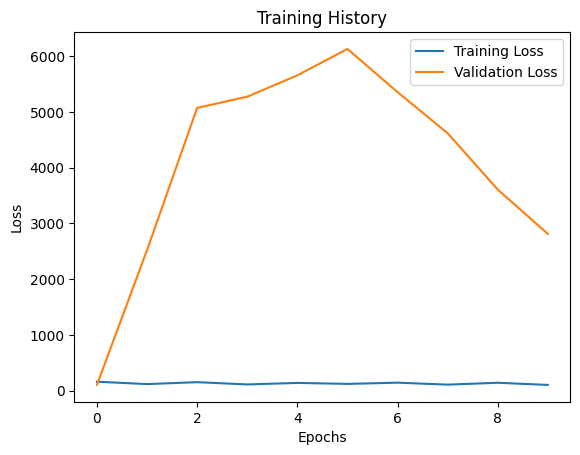

In [48]:
# Plot training history
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training History")
plt.xlabel("Epochs")  # X-axis label
plt.ylabel("Loss")    # Y-axis label
plt.legend()
plt.show()

---

## Conclusion
This notebook demonstrates a simplified training pipeline using a limited amount of data. Adapt this template with real data and models for your specific use case.